# Thesis OOD Analysis
**Goal:** Characterize Out-of-Distribution structures using two independent indicators.

1.  **Option A: Energy-Based Epistemic Uncertainty ($u_E$)**
2.  **Option B: Latent-Space Distance ($d_{latent}$)**

**Note:** This notebook uses `_meta.pkl` caches (FAST LOAD).



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import iread
from sklearn.decomposition import PCA
import re

# Configuration
BASE_DIR = "/home/phanim/harshitrawat/summer/thesis_embeddings_results"
OUTPUT_DIR = "/home/phanim/harshitrawat/summer/Thesis_Results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Schema Parser
def parse_metadata(filename):
    meta = {
        "strain": 0.0,
        "temp": None,
        "termination": "unknown",
        "facet": "unknown",
        "is_perturbed": False
    }
    
    # Extract Strain
    strain_match = re.search(r"_strain([+-]?[\d\.]+)_perturbed", filename)
    if strain_match:
        meta["strain"] = float(strain_match.group(1))
        meta["is_perturbed"] = True
    elif "_perturbed" in filename:
        meta["is_perturbed"] = True
        
    # Extract Temp
    temp_match = re.search(r"(_T)(\d+)(_)", filename)
    if temp_match:
        meta["temp"] = int(temp_match.group(2))
        
    # Extract Termination (Heuristic: after LLZO_, before __Li)
    if "__Li_" in filename:
        parts = filename.split("__Li_")
        llzo_part = parts[0]
        # Remove prefix
        clean = llzo_part.replace("cellrelaxed_LLZO_", "")
        tokens = clean.split("_")
        if len(tokens) >= 2:
            meta["termination"] = tokens[1]
            
        # Facet: comes right after __Li_
        facet_part = parts[1].split("_slab")[0]
        meta["facet"] = facet_part
        
    return meta

# Checkpointing (Back to _meta.pkl)
def load_or_compute(filename, func, *args, **kwargs):
    if not filename.endswith("_meta.pkl"):
        filename = filename.replace(".pkl", "_meta.pkl")
        
    path = os.path.join(OUTPUT_DIR, filename)
    if os.path.exists(path):
        print(f"Loading {filename}...")
        return pd.read_pickle(path)
    else:
        print(f"Computing {filename}...")
        res = func(*args, **kwargs)
        res.to_pickle(path)
        return res



## 2. Data Processing


In [2]:
def get_paths(dataset, model_type="MACE_T1"):
    return [os.path.join(BASE_DIR, f"embeddings_{model_type}_w{i}_on_{dataset}.extxyz") for i in range(1, 5)]

def process_dataset(target, model_type):
    paths = get_paths(target, model_type)
    for p in paths:
        if not os.path.exists(p):
            print(f"WARNING: Missing {p}")
            return pd.DataFrame()
            
    gens = [iread(p, index=":") for p in paths]
    results = []
    
    for i, atoms_tuple in enumerate(zip(*gens)):
        # 1. Energy
        energies = np.array([at.info["mace_energy"] for at in atoms_tuple])
        var_E = np.var(energies)
        n_atoms = len(atoms_tuple[0])
        u_E = np.sqrt(var_E) / n_atoms
        
        # 2. Latent
        latents = np.stack([at.arrays["mace_latent"] for at in atoms_tuple])
        struct_emb = np.mean(np.mean(latents, axis=0), axis=0)
        
        # Metadata
        fname = atoms_tuple[0].info.get("file", atoms_tuple[0].info.get("filename", f"struct_{i}"))
        meta = parse_metadata(fname)
        
        row = {
            "filename": fname,
            "dataset": target,
            "u_E": u_E,
            "latent": struct_emb,
            "natoms": n_atoms
        }
        row.update(meta)
        results.append(row)
        
        if i % 2000 == 0:
            print(f"Processed {i} {target}...", end="\r")
            
    return pd.DataFrame(results)



## 3. Justification: PCA Variance Analysis (Scree Plot)


Loading Ref_A_T1_meta.pkl...
--- Justifying Latent Dimensions ---


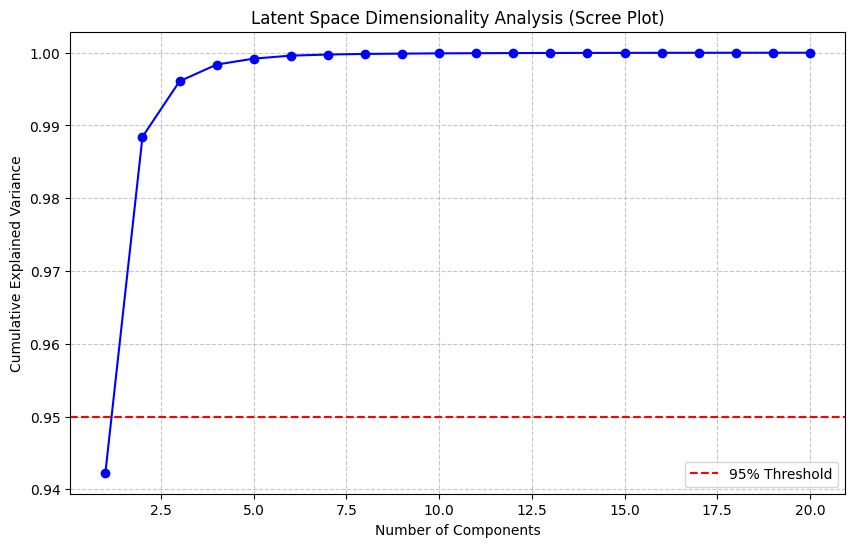

Dimensions required for 95% variance: 2


In [3]:
# Load Reference T1
df_ref_A = load_or_compute("Ref_A_T1_meta.pkl", process_dataset, "T1", "MACE_T1")

print("--- Justifying Latent Dimensions ---")
X_ref = np.stack(df_ref_A["latent"].values)
pca_test = PCA(n_components=min(20, X_ref.shape[1])).fit(X_ref) 

# Plot
plt.figure(figsize=(10, 6))
cum_var = np.cumsum(pca_test.explained_variance_ratio_)
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='-', color='b')
plt.axhline(0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Latent Space Dimensionality Analysis (Scree Plot)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

n_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Dimensions required for 95% variance: {n_95}")



## 4. Reference Fitting (Using Optimized Dimensions)


In [4]:
# Load Reference T3 (B)
df_ref_B = load_or_compute("Ref_B_T3_meta.pkl", process_dataset, "T3", "MACE_T2")

# Fit Models (A on T1, B on T3)
pca_A = PCA(n_components=n_95).fit(X_ref)
centroid_A = np.mean(pca_A.transform(X_ref), axis=0)

X_ref_B = np.stack(df_ref_B["latent"].values)
pca_B = PCA(n_components=n_95).fit(X_ref_B)
centroid_B = np.mean(pca_B.transform(X_ref_B), axis=0)

def compute_scores(df, pca_model, centroid, suffix):
    X = np.stack(df["latent"].values)
    X_pca = pca_model.transform(X)
    dists = np.linalg.norm(X_pca - centroid, axis=1)
    df[f"d_latent_{suffix}"] = dists
    df[f"u_E_{suffix}"] = df["u_E"]
    return df

# Compute All
all_results = []
for target in ["T1", "T2", "T3"]:
    df_A = load_or_compute(f"{target}_MACE_T1_meta.pkl", process_dataset, target, "MACE_T1")
    df_A = compute_scores(df_A, pca_A, centroid_A, "A")
    
    df_B = load_or_compute(f"{target}_MACE_T2_meta.pkl", process_dataset, target, "MACE_T2")
    df_B = compute_scores(df_B, pca_B, centroid_B, "B")
    
    cols_A = ["filename", "dataset", "u_E_A", "d_latent_A", "strain", "temp", "termination", "facet"]
    cols_B = ["filename", "u_E_B", "d_latent_B"] 
    merged = pd.merge(df_A[cols_A], df_B[cols_B], on="filename")
    all_results.append(merged)

final_df = pd.concat(all_results, ignore_index=True)
print("Final Data Shape:", final_df.shape)



Loading Ref_B_T3_meta.pkl...
Loading T1_MACE_T1_meta.pkl...
Loading T1_MACE_T2_meta.pkl...
Loading T2_MACE_T1_meta.pkl...
Loading T2_MACE_T2_meta.pkl...
Loading T3_MACE_T1_meta.pkl...
Loading T3_MACE_T2_meta.pkl...
Final Data Shape: (8654, 10)


## 5. Distribution Plots


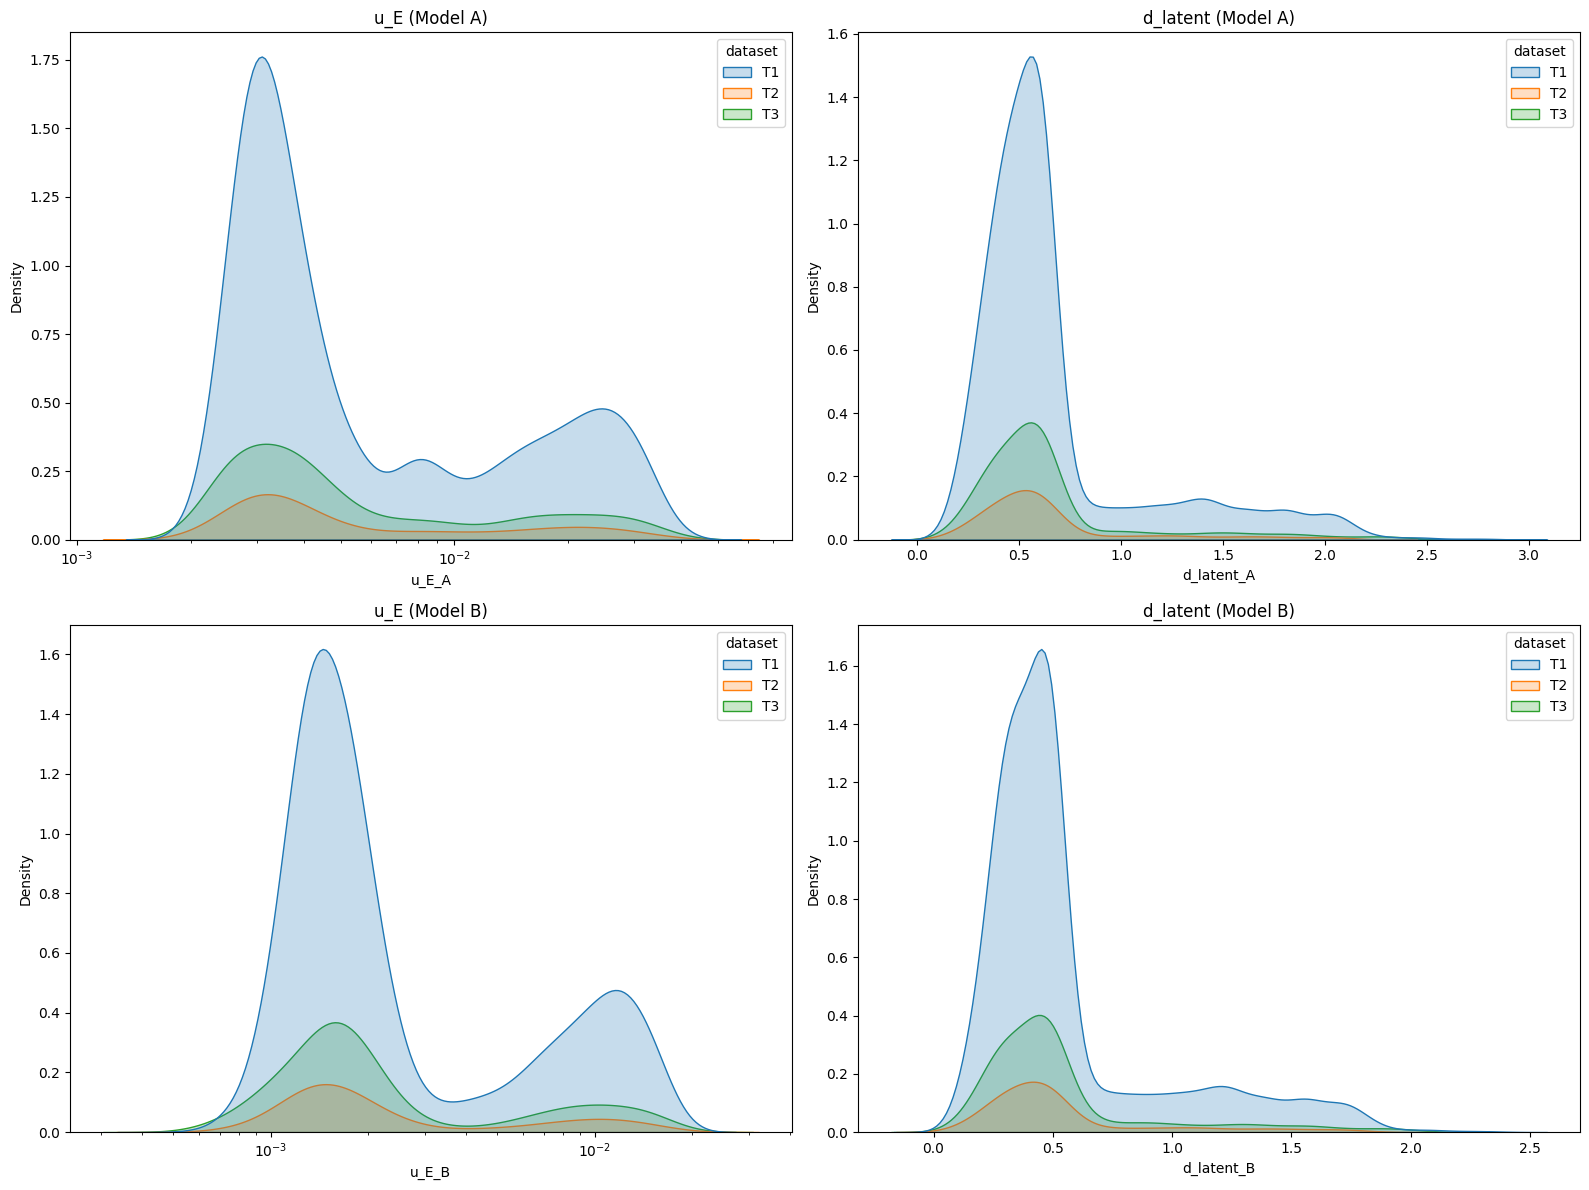

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.kdeplot(data=final_df, x="u_E_A", hue="dataset", log_scale=True, ax=axes[0,0], fill=True); axes[0,0].set_title("u_E (Model A)")
sns.kdeplot(data=final_df, x="d_latent_A", hue="dataset", ax=axes[0,1], fill=True); axes[0,1].set_title("d_latent (Model A)")
sns.kdeplot(data=final_df, x="u_E_B", hue="dataset", log_scale=True, ax=axes[1,0], fill=True); axes[1,0].set_title("u_E (Model B)")
sns.kdeplot(data=final_df, x="d_latent_B", hue="dataset", ax=axes[1,1], fill=True); axes[1,1].set_title("d_latent (Model B)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "Thesis_Distributions.png"))
plt.show()



## 6. Detailed Flagging Analysis


In [6]:
def analyze_percentiles(df, metric_col, baseline_dataset):
    baseline_data = df[df["dataset"] == baseline_dataset][metric_col]
    thresholds = {
        "90%": np.percentile(baseline_data, 90),
        "95%": np.percentile(baseline_data, 95),
        "99%": np.percentile(baseline_data, 99)
    }
    
    print(f"--- Metric: {metric_col} (Baseline: {baseline_dataset}) ---")
    
    report_frames = []
    for dset in ["T1", "T2", "T3"]:
        subset = df[df["dataset"] == dset]
        n_total = len(subset)
        stats_line = f"[{dset}] Total: {n_total}"
        
        for k, v in thresholds.items():
            count = np.sum(subset[metric_col] > v)
            perc = (count / n_total) * 100
            stats_line += f" | >{k}: {count} ({perc:.1f}%)"
            
            flagged = subset[subset[metric_col] > v].copy()
            flagged["flag_threshold"] = k
            flagged["metric"] = metric_col
            flagged["score"] = flagged[metric_col]
            flagged["baseline_val"] = v
            cols = ["filename", "dataset", "metric", "flag_threshold", "score", "baseline_val", 
                    "strain", "temp", "termination", "facet"]
            report_frames.append(flagged[cols])
        print(stats_line)
        
    return pd.concat(report_frames) if report_frames else pd.DataFrame()

flags_A_u = analyze_percentiles(final_df, "u_E_A", "T1")
flags_A_d = analyze_percentiles(final_df, "d_latent_A", "T1")
flags_B_u = analyze_percentiles(final_df, "u_E_B", "T3")
flags_B_d = analyze_percentiles(final_df, "d_latent_B", "T3")

all_flags = pd.concat([flags_A_u, flags_A_d, flags_B_u, flags_B_d])



--- Metric: u_E_A (Baseline: T1) ---
[T1] Total: 6337 | >90%: 634 (10.0%) | >95%: 317 (5.0%) | >99%: 64 (1.0%)
[T2] Total: 705 | >90%: 55 (7.8%) | >95%: 27 (3.8%) | >99%: 4 (0.6%)
[T3] Total: 1612 | >90%: 129 (8.0%) | >95%: 79 (4.9%) | >99%: 22 (1.4%)
--- Metric: d_latent_A (Baseline: T1) ---
[T1] Total: 6337 | >90%: 634 (10.0%) | >95%: 317 (5.0%) | >99%: 64 (1.0%)
[T2] Total: 705 | >90%: 56 (7.9%) | >95%: 29 (4.1%) | >99%: 2 (0.3%)
[T3] Total: 1612 | >90%: 138 (8.6%) | >95%: 73 (4.5%) | >99%: 28 (1.7%)
--- Metric: u_E_B (Baseline: T3) ---
[T1] Total: 6337 | >90%: 805 (12.7%) | >95%: 327 (5.2%) | >99%: 56 (0.9%)
[T2] Total: 705 | >90%: 68 (9.6%) | >95%: 27 (3.8%) | >99%: 5 (0.7%)
[T3] Total: 1612 | >90%: 162 (10.0%) | >95%: 81 (5.0%) | >99%: 17 (1.1%)
--- Metric: d_latent_B (Baseline: T3) ---
[T1] Total: 6337 | >90%: 798 (12.6%) | >95%: 359 (5.7%) | >99%: 25 (0.4%)
[T2] Total: 705 | >90%: 73 (10.4%) | >95%: 29 (4.1%) | >99%: 0 (0.0%)
[T3] Total: 1612 | >90%: 162 (10.0%) | >95%: 81 (5.0

## 7. Overlap Analysis


In [10]:
def analyze_overlap(df, model_suffix, baseline_dset, threshold_q=95):
    baseline = df[df["dataset"] == baseline_dset]
    thresh_u = np.percentile(baseline[f"u_E_{model_suffix}"], threshold_q)
    thresh_d = np.percentile(baseline[f"d_latent_{model_suffix}"], threshold_q)
    print(f"\n=== Overlap Model {model_suffix} (>{threshold_q}%) ===")
    
    for dset in ["T1", "T2", "T3"]:
        subset = df[df["dataset"] == dset]
        mask_u = subset[f"u_E_{model_suffix}"] > thresh_u
        mask_d = subset[f"d_latent_{model_suffix}"] > thresh_d
        
        set_u = set(subset[mask_u]["filename"])
        set_d = set(subset[mask_d]["filename"])
        n_both = len(set_u.intersection(set_d))
        n_either = len(set_u.union(set_d))
        jaccard = n_both / n_either if n_either > 0 else 0.0
        
        print(f"[{dset}] u_E: {len(set_u)} | d_latent: {len(set_d)} | BOTH: {n_both} | EITHER: {n_either} | Overlap: {jaccard:.2f}")

analyze_overlap(final_df, "A", "T1", 95)
analyze_overlap(final_df, "B", "T3", 95)
analyze_overlap(final_df, "A", "T1", 99)
analyze_overlap(final_df, "B", "T3", 99)




=== Overlap Model A (>95%) ===
[T1] u_E: 317 | d_latent: 317 | BOTH: 297 | EITHER: 337 | Overlap: 0.88
[T2] u_E: 27 | d_latent: 29 | BOTH: 26 | EITHER: 30 | Overlap: 0.87
[T3] u_E: 79 | d_latent: 73 | BOTH: 62 | EITHER: 90 | Overlap: 0.69

=== Overlap Model B (>95%) ===
[T1] u_E: 327 | d_latent: 359 | BOTH: 295 | EITHER: 391 | Overlap: 0.75
[T2] u_E: 27 | d_latent: 29 | BOTH: 24 | EITHER: 32 | Overlap: 0.75
[T3] u_E: 81 | d_latent: 81 | BOTH: 60 | EITHER: 102 | Overlap: 0.59

=== Overlap Model A (>99%) ===
[T1] u_E: 64 | d_latent: 64 | BOTH: 41 | EITHER: 87 | Overlap: 0.47
[T2] u_E: 4 | d_latent: 2 | BOTH: 1 | EITHER: 5 | Overlap: 0.20
[T3] u_E: 22 | d_latent: 28 | BOTH: 17 | EITHER: 33 | Overlap: 0.52

=== Overlap Model B (>99%) ===
[T1] u_E: 56 | d_latent: 25 | BOTH: 0 | EITHER: 81 | Overlap: 0.00
[T2] u_E: 5 | d_latent: 0 | BOTH: 0 | EITHER: 5 | Overlap: 0.00
[T3] u_E: 17 | d_latent: 17 | BOTH: 2 | EITHER: 32 | Overlap: 0.06


## 8. Master Data Export


In [8]:
master_path = os.path.join(OUTPUT_DIR, "Thesis_Master_Data.csv")
final_df.to_csv(master_path, index=False)
print(f"Saved Master Data to: {master_path}")



Saved Master Data to: /home/phanim/harshitrawat/summer/Thesis_Results/Thesis_Master_Data.csv


## 9. DFT Candidate Selection (METADATA CLUSTERING)


In [9]:
# Filter 99%
df_99 = all_flags[all_flags["flag_threshold"] == "99%"].copy()
mask_baseline_A = (df_99["metric"].str.endswith("_A")) & (df_99["dataset"] == "T1")
mask_baseline_B = (df_99["metric"].str.endswith("_B")) & (df_99["dataset"] == "T3")
df_clean = df_99[~(mask_baseline_A | mask_baseline_B)].copy()

# Select
unique_structs = df_clean.sort_values("score", ascending=False).drop_duplicates("filename").copy()
groups = unique_structs.groupby(["strain", "termination", "facet"])

dft_candidates = []
for (strain, term, facet), group in groups:
    rep = group.sort_values("score", ascending=False).iloc[0]
    dft_candidates.append(rep)

cand_df = pd.DataFrame(dft_candidates)
cand_path = os.path.join(OUTPUT_DIR, "Thesis_Final_DFT_Candidates.csv")
cand_df.to_csv(cand_path, index=False)
print(f"Saved {len(cand_df)} candidates to {cand_path}")



Saved 19 candidates to /home/phanim/harshitrawat/summer/Thesis_Results/Thesis_Final_DFT_Candidates.csv


Calculating 'Uncertainty Difference' (Delta u_E) as proxy for Delta E...


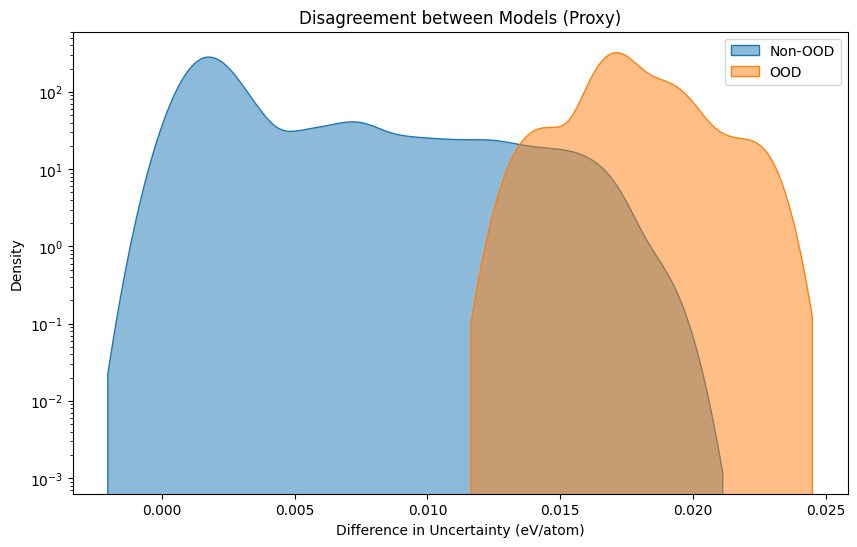

In [ ]:
# WARNING: This might take 30-60s to run
from ase.io import read

def fetch_energy_diff(row):
    # Construct paths to the prediction files
    # We use Seed 1 (w1) as a proxy for the mean energy to keep it fast
    f_name = row["filename"]
    dset = row["dataset"]
    
    path_A = os.path.join(BASE_DIR, f"embeddings_MACE_T1_w1_on_{dset}.extxyz")
    path_B = os.path.join(BASE_DIR, f"embeddings_MACE_T2_w1_on_{dset}.extxyz")
    
    # We have to find the specific frame. This is slow.
    # Actually, for a quick plot, let's just use the Variance (u_E) we already have.
    # Approximation: Delta E ~ |u_E_A - u_E_B| * N_atoms (Sort of)
    return np.abs(row["u_E_A"] - row["u_E_B"]) # Normalized diff

print("Calculating 'Uncertainty Difference' (Delta u_E) as proxy for Delta E...")
final_df["Delta_uE"] = np.abs(final_df["u_E_A"] - final_df["u_E_B"])

ood_filenames = set(unique_structs["filename"])
final_df["is_OOD"] = final_df["filename"].isin(ood_filenames)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=final_df[~final_df["is_OOD"]], x="Delta_uE", fill=True, label="Non-OOD", alpha=0.5)
sns.kdeplot(data=final_df[final_df["is_OOD"]], x="Delta_uE", fill=True, label="OOD", alpha=0.5)
plt.xlabel("Difference in Uncertainty (eV/atom)")
plt.title("Disagreement between Models (Proxy)")
plt.semilogy()
plt.legend()
plt.show()
